In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fixed_point
from numba import njit, float64, float32, int64, prange
from numba.experimental import jitclass

# Replication of Rust (1987)

The manual, raw data, and other code is located in the folder `nxfp` and was sourced from [here](https://zenodo.org/record/3385050#.YjTy3C-B1QI). 

## Part 1: Data manipulation

This is by far the most tedious part of the replication.

The data is contained in ASCII files which must first be reshaped and then have the information contained in the first 11 rows be extracted.

The mileage given is the *accumulated* mileage, meaning it isn't reset to 0 after engine replacement. We will also create a separate dataset where mileage following the replacement has the mileage at replacement subtracted. Note that mileage *at the time of replacement* isn't set to 0, since the decision maker observes the total mileage at that time before deciding whether to replace.

In [2]:
# Import the raw data
b1_raw = pd.read_csv('nfxp/dat/g870.asc', header=None)
b1_raw = pd.DataFrame(b1_raw.values.reshape((15, int(len(b1_raw) / 15)))).T

b2_raw = pd.read_csv('nfxp/dat/rt50.asc', header=None)
b2_raw = pd.DataFrame(b2_raw.values.reshape((4, int(len(b2_raw) / 4)))).T

b3_raw = pd.read_csv('nfxp/dat/t8h203.asc', header=None)
b3_raw = pd.DataFrame(b3_raw.values.reshape((48, int(len(b3_raw) / 48)))).T

b4_raw = pd.read_csv('nfxp/dat/a530875.asc', header=None)
b4_raw = pd.DataFrame(b4_raw.values.reshape((37, int(len(b4_raw) / 37)))).T

In [3]:
def extract_info(b):

    # Create separate dataframe for bus info
    new_index = ['' for x in range(11)]
    new_index[0] = 'bus_number'
    new_index[1] = 'month_purchased'
    new_index[2] = 'year_purchased'
    new_index[3] = 'month_replacement_1'
    new_index[4] = 'year_replacement_1'
    new_index[5] = 'odometer_replacement_1'
    new_index[6] = 'month_replacement_2'
    new_index[7] = 'year_replacement_2'
    new_index[8] = 'odometer_replacement_2'
    new_index[9] = 'month_begin'
    new_index[10] = 'year_begin'
    b_info = b.iloc[:11]
    b_info.index = new_index
    b_info = b_info.T.set_index('bus_number').T
    
    # Set bus number to be column headers
    b = b.T.set_index([0]).T

    # Drop bus info
    b = b[10:]

    # Add dates to row index
    month = b_info.loc["month_begin"].values[0]
    year = b_info.loc["year_begin"].values[0]
    b.index = pd.date_range(f"{year}-{month}-01", periods=len(b), freq="MS")

    # Fix month and years of odometer replacements to be date corresponding to odometer replacement
    # Rust points out this differs in some cases
    col_map = pd.DataFrame(b.columns).to_dict()[0]
    for o in ['1', '2']:
        x, y = np.where(b > b_info.loc[f'odometer_replacement_{o}', :])
        replacement = pd.DataFrame([x, y], index=['row', 'column']).T
        replacement = replacement.groupby('column').min()
        replacement.index = replacement.index.map(col_map)
        replacement[f'month_{o}'] = replacement['row'].apply(lambda x: b.index[x].month)
        replacement[f'year_{o}'] = replacement['row'].apply(lambda x: np.mod(b.index[x].year, 1900))
        replacement[f'replace_{o}'] = replacement['row'].apply(lambda x: pd.Timestamp(year=b.index[x].year, month=b.index[x].month, day=1))
        replacement[replacement.row == 0] = 0
        # Append checks to dataframe
        replacement = replacement.drop('row', axis=1)
        b_info = pd.concat([b_info, replacement.T])

    return b_info, b

In [4]:
def update_b(b, b_info):
    '''Resets mileage after replacement and returns investment decision matrix'''

    b_reset = b.copy()
    b_i = b.copy()
    b_i[:] = 0

    for col in b.iteritems():

        bus_number = col[0]
        bus_info = b_info[bus_number].copy()

        for r in ('1'):
            replace_date = bus_info[f'replace_{r}']

            if replace_date != 0:

                if r == '1':
                    odometer_replacement = b.loc[replace_date, bus_number]

                if r == '2':
                    # Subtract mileage from earlier replacement
                    replace_date_1 = bus_info[f'replace_1']
                    previous_mileage = b.loc[replace_date_1, bus_number]
                    odometer_replacement = b.loc[replace_date, bus_number] - previous_mileage
                
                bus_odometer = b_reset[bus_number].copy()
                
                # Find replacement date then subtract odometer replacement value from
                # odometer readings after replacement
                bus_odometer[bus_odometer.index > replace_date] -= odometer_replacement
                b_reset[bus_number] = bus_odometer

                # Set decision = 1 on replacement date
                b_i.loc[replace_date, bus_number] = 1

    return b, b_reset, b_i

In [5]:
def discretize(b, d=5000):
    '''Discretizes odometer data into buckets of length d'''

    return np.floor(b / d)

In [6]:
# Extract information from the raw datasets
b1_info, b1 = extract_info(b1_raw)
b2_info, b2 = extract_info(b2_raw)
b3_info, b3 = extract_info(b3_raw)
b4_info, b4 = extract_info(b4_raw)

# Get relevant data and merge
b1, b1_reset, b1_i = update_b(b1, b1_info)
b2, b2_reset, b2_i = update_b(b2, b2_info)
b3, b3_reset, b3_i = update_b(b3, b3_info)
b4, b4_reset, b4_i = update_b(b4, b4_info)

b = pd.concat([b1, b2, b3, b4], axis=1, join='outer')
b_reset = pd.concat([b1_reset, b2_reset, b3_reset, b4_reset], axis=1, join='outer')
b_i = pd.concat([b1_i, b2_i, b3_i, b4_i], axis=1, join='outer')

# Create dataframe for likelihood estimation
b_data = pd.concat([discretize(b_reset.T.stack()), b_i.T.stack()], axis=1)
b_data.columns = ['state', 'decision']


The transition probabilities are found by discretizing the data set into intervals of length 5000. The transition states $d$ are given as
$$
d=
\begin{cases}
0 \quad \Delta mileage \in [0, 5000) \\
1 \quad \Delta mileage \in [5000, 10000) \\
2 \quad \Delta mileage \in [10000, \infty)
\end{cases}
$$

Then the empirical frequency of $d$ gives the transition probabilities.

In [ ]:
# Discretize the odometer readings
b_discrete = discretize(b_reset)

# Calculate the states d = {0, 1, 2}
b_state = b_discrete - b_discrete.shift(1)

# Find the transition probabilities
N = b_state.notna().sum().sum()
p = (b_state == 0).sum().sum() / N
q = (b_state == 1).sum().sum() / N

## Part 2: Setting up the model

The following class will contain all the relevant parameters in the model. I use `@jitclass` to be able to speed up my code with Numba later on. This requires telling Numba what data type each parameter is.

In [7]:
spec = [('β', float64),
        ('θ_1', float64),
        ('RC', float64),
        ('T', int64),
        ('p', float64),
        ('q', float64),
        ('scale', float64),
        ('P', float64[:, :]),
        ('x', float64[:])]

@jitclass(spec)
class Rust(object):

    def __init__(self, β=0.9999, θ_1=3.6, 
                 RC=10, T=90, p=0.3497, 
                 q=0.6387, scale=0.001):

        self.β = β
        self.θ_1 = θ_1
        self.RC = RC
        self.T = T
        self.p = p
        self.q = q
        self.scale = scale

        # Construct transition matrix
        P = np.zeros((T, T))
        np.fill_diagonal(P, p)
        P += np.diag(np.ones(T - 1) * q, 1)
        P += np.diag(np.ones(T - 2) * (1 - p - q), 2)
        P[:, -1] += 1 - P.sum(1)  # Adjust to sum to 1
        self.P = P

        # Statespace of x
        self.x = np.arange(T, dtype=np.float64)

Next I define the cost and utility functions 

In [8]:
@njit
def c(x, rust):
    '''Linear cost function'''

    scale = rust.scale
    θ_1 = rust.θ_1

    return scale * θ_1 * x

@njit
def u(x, i, rust):
    '''Utility function'''
    
    θ_1 = rust.θ_1
    scale = rust.scale
    RC = rust.RC

    if i == 0:
        return -c(x, rust)

    if i == 1:
        return -c(x, rust) - RC

## Part 3: Solving the inner loop

The inner loop is a straight-forward dynamic programming problem which does not depend on the data.

Note that the number of iterations in each loop is high, so `maxiter` should be set to a large number. To avoid overflow issues in the exponential function, the current expected value is subtracted from the conditional values, and then re-added after taking the log of the exponential.

In [9]:
@njit
def solve_EV(rust, tol=1e-3, maxiter=300000, print_flag=False):

    T = rust.T
    β = rust.β
    P = np.ascontiguousarray(rust.P)
    RC = rust.RC
    x = rust.x
    θ_1 = rust.θ_1
    scale = rust.scale

    # Initial guess of value function
    EV = np.zeros(T)

    # Bellman operator
    def T(EV):
        wait = u(x, 0, rust) + β * EV
        replace = u(x[0], 1, rust) + β * EV[0]
        EV_new = np.exp(replace - EV) + np.exp(wait - EV)
        EV_new = P @ (np.log(EV_new) + EV)
        return EV_new

    # Find the fixed point of Bellman operator
    i = 0
    dist = 1e3
    for i in prange(maxiter):
        EV_new = T(EV)
        dist = np.linalg.norm(EV - EV_new)

        if dist < tol:
            if print_flag:
                print(f'Converged in {i} iterations')
            return EV
        else:
            i += 1
            EV = EV_new.copy()
    
    if print_flag:
        print('Reached max iterations')
        
    return EV

Here is what the solution of the inner loop looks like given some starting values.

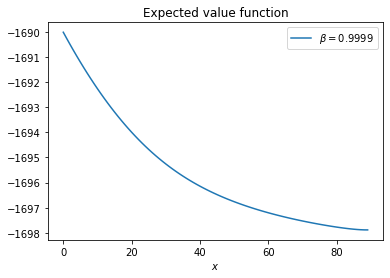

In [10]:
r = Rust(p=p, q=q)
EV_star = solve_EV(r)
plt.plot(r.x, EV_star, label=rf'$\beta = {r.β}$')

plt.title('Expected value function')
plt.xlabel('$x$')
plt.legend()
plt.show()

## Part 4: Solving the outer loop

The outer loop solves for the parameters using maximum likelihood estimation.

Given some parameters, we find the solution to the dynamic programming problem and use the expected values to calculate the conditional probability of waiting or replacing the engine. Then using our data, we construct the log likelihood function by summing up the conditional probability that corresponds to the state and decision for each observation. As such, the only data needed is the decision $i$ and state $x$. The state is the discretized mileage accounting for previous engine replacements.

Here is what the dataframe looks like:

In [11]:
b_data.head()

state  decision
0                               
4403 1983-05-01    0.0       0.0
     1983-06-01    0.0       0.0
     1983-07-01    1.0       0.0
     1983-08-01    2.0       0.0
     1983-09-01    3.0       0.0

The formula for conditional probabilities results from the assumption that the errors are Gumbel distributed.

$$
Pr(i|x, \theta) = \frac{exp(u(x, i, \theta_1) + \beta EV(x, i))}{\sum_j exp(u(x, j, \theta_1) + \beta EV(x, j))}
$$


In [12]:
def conditional_probability(x, EV, rust):

    β = r.β
    x = r.x
    P = r.P

    wait = u(x, 0, rust) + β * P @ EV
    replace = u(x[0], 1, rust) + β * EV[0]
    P_wait = 1 / (1 + np.exp(replace - wait))
    P_replace = 1 - P_wait
    
    return P_wait, P_replace


The log-likelihood function first solves the inner loops to find the expected value given the parameters, then returns the negative of the log-likelihood to minimize.

In [13]:
def log_likelihood(θ,             # Parameters to search over 
                   b_data):       # Data consists of states and decisions

    # Guess of parameters
    θ_1, RC = θ

    # Solve inner loop with these parameters
    r = Rust(θ_1=θ_1, RC=RC)
    EV_star = solve_EV(r)

    # Choice probabilities conditional on x and i
    P_wait, P_replace = conditional_probability(r.x, EV_star, r)

    # Log likelihood is sum of conditional probabilities given observed data
    logL = 0
    for decision, state in zip(b_data.decision, b_data.state):
        state = int(state)

        # Wait
        if decision == 0:
            logL += np.log(P_wait[state])
        
        # Replace
        if decision == 1:
            logL += np.log(P_replace[state])

    return -logL

In [14]:
θ_star = minimize(log_likelihood, x0=(0.1, 10), args=(b_data), method='Nelder-Mead').x

The solution is very close to the solution in Rust's paper:

In [15]:
θ_star

array([ 2.62056276, 10.03912783])

## Part 5: Plotting the results

In [16]:
# Use the solution to set up a new model
r_star = Rust(p=p, q=q, θ_1=θ_star[0], RC=θ_star[1])
EV_star = solve_EV(r_star)

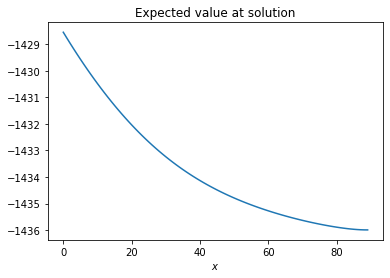

In [17]:
plt.plot(r_star.x, EV_star)
plt.title('Expected value at solution')
plt.xlabel('$x$')
plt.show()

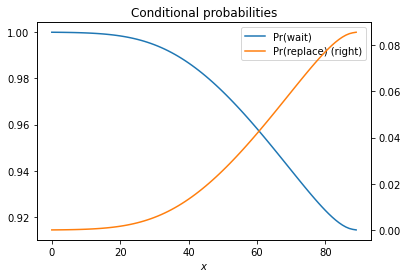

In [18]:
P_star = pd.DataFrame(conditional_probability(r_star.x, EV_star, r_star)).T
P_star.iloc[:, 0].plot(label='Pr(wait)', legend=True, title='Conditional probabilities', xlabel='$x$')
P_star.iloc[:, 1].plot(secondary_y=True, label='Pr(replace)', legend=True)
plt.show()